In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import random

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

seed_value= 0
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481] #살인 및 무기징역 제외

In [4]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 256

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (len(dfc.columns[1:]),))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (len(dfl.columns[1:]),))

dense_layer_1_1 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 20, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.5)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.5)(dense_layer_2_4)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0825_6.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 200
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

25350


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3])


dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_4)

model = tf.keras.Model(inputs=[input_1, input_2, input_3], outputs=output)

In [12]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adamax(learning_rate=0.005), metrics=['mse', 'mae'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 200)     5070000     input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 153)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 567)]        0                                            
______________________________________________________________________________________________

In [13]:
history = model.fit(x=[X1_train, X2_train, X3_train], y=y_train, batch_size=32, epochs=100, verbose=1, validation_split=0.1)

Train on 3705 samples, validate on 412 samples
Epoch 1/120
3705/3705 [==============================] - 6s 2ms/sample - loss: 1470.5449 - mse: 1283.0790 - mae: 19.1908 - val_loss: 1235.9360 - val_mse: 1000.5850 - val_mae: 16.6087
Epoch 2/120
3705/3705 [==============================] - 3s 893us/sample - loss: 1061.1438 - mse: 809.3964 - mae: 15.5101 - val_loss: 1075.6790 - val_mse: 805.0027 - val_mae: 16.1729
Epoch 3/120
3705/3705 [==============================] - 4s 969us/sample - loss: 898.5754 - mse: 608.0004 - mae: 14.1959 - val_loss: 976.3627 - val_mse: 675.9138 - val_mae: 15.0105
Epoch 4/120
3705/3705 [==============================] - 4s 968us/sample - loss: 725.0544 - mse: 426.2306 - mae: 12.3354 - val_loss: 881.2635 - val_mse: 579.9148 - val_mae: 12.1402
Epoch 5/120
3705/3705 [==============================] - 3s 895us/sample - loss: 645.2278 - mse: 342.4596 - mae: 11.6160 - val_loss: 919.2042 - val_mse: 615.8489 - val_mae: 12.1544
Epoch 6/120
3705/3705 [=====================

Epoch 46/120
3705/3705 [==============================] - 4s 948us/sample - loss: 410.5808 - mse: 215.8702 - mae: 8.6880 - val_loss: 627.4988 - val_mse: 433.8299 - val_mae: 10.8893
Epoch 47/120
3705/3705 [==============================] - 3s 925us/sample - loss: 390.1535 - mse: 202.1491 - mae: 8.4997 - val_loss: 654.9097 - val_mse: 468.0376 - val_mae: 10.7865
Epoch 48/120
3705/3705 [==============================] - 4s 947us/sample - loss: 381.5754 - mse: 199.1856 - mae: 8.5324 - val_loss: 626.8597 - val_mse: 438.8336 - val_mae: 10.8520
Epoch 49/120
3705/3705 [==============================] - 4s 949us/sample - loss: 418.3462 - mse: 232.0983 - mae: 8.7682 - val_loss: 631.9030 - val_mse: 439.2751 - val_mae: 10.6259
Epoch 50/120
3705/3705 [==============================] - 3s 940us/sample - loss: 380.9461 - mse: 190.7642 - mae: 8.3147 - val_loss: 615.2574 - val_mse: 433.4238 - val_mae: 10.8885
Epoch 51/120
3705/3705 [==============================] - 3s 942us/sample - loss: 358.9375 - ms

3705/3705 [==============================] - 4s 951us/sample - loss: 320.5106 - mse: 170.6555 - mae: 7.6942 - val_loss: 579.8956 - val_mse: 433.7050 - val_mae: 10.4270
Epoch 92/120
3705/3705 [==============================] - ETA: 0s - loss: 312.5072 - mse: 161.8370 - mae: 7.548 - 3s 935us/sample - loss: 312.6417 - mse: 162.0066 - mae: 7.5596 - val_loss: 597.1295 - val_mse: 451.4492 - val_mae: 11.0877
Epoch 93/120
3705/3705 [==============================] - 4s 951us/sample - loss: 291.0882 - mse: 145.0721 - mae: 7.2581 - val_loss: 609.3558 - val_mse: 459.3344 - val_mae: 11.9860
Epoch 94/120
3705/3705 [==============================] - 4s 973us/sample - loss: 311.4723 - mse: 160.6571 - mae: 7.5426 - val_loss: 542.1093 - val_mse: 389.0493 - val_mae: 10.4744
Epoch 95/120
3705/3705 [==============================] - 3s 939us/sample - loss: 294.0525 - mse: 143.8113 - mae: 7.2823 - val_loss: 543.0572 - val_mse: 395.5324 - val_mae: 10.6507
Epoch 96/120
3705/3705 [============================

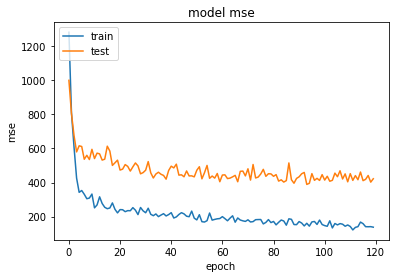

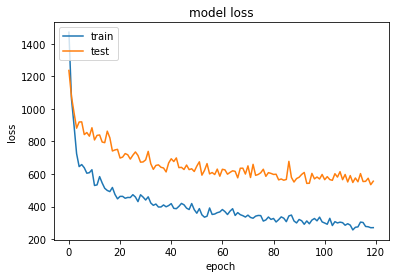

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(x=[X1_test, X2_test, X3_test], y=y_test, verbose=1)

print(score)
#print("Test Score:", score[0])
print("Test MSE:", score[1])
print("Test MAE: ", score[2])

458/458 [==============================] - 0s 523us/sample - loss: 543.8476 - mse: 410.4413 - mae: 10.3718
[543.8475742923121, 410.44128, 10.371786]
Test MSE: 410.44128
Test MAE:  10.371786
